# Flood segmentation

### Importing libraries

In [1]:
# basic torch imports
import torch
from torchvision.transforms import ToTensor, Resize
import torch.nn as nn
import torch.nn.functional as F
# other important imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# albumentations and image handling
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset , Subset, random_split
from PIL import Image

# utils
from src import utils

# misc imports
import time
import os

# adding parent directory to path
import sys
sys.path.append('..')

# Optimisation for training
from torch.cuda.amp import GradScaler, autocast

# Setting defaults for torch, seed and device
torch.manual_seed(42)
np.random.seed(42)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

### Creating the list of images

In [3]:
image_path = os.listdir(os.path.join('archive', 'Image'))
mask_path = os.listdir(os.path.join('archive', 'Mask'))
train_indices = np.random.choice(len(image_path), size=int(0.8*len(image_path)), replace=False)
test_indices = np.array(list(set(range(len(image_path))) - set(train_indices)))

### Splitting into training and testing

In [4]:
train_image_path = np.take(image_path, train_indices)
train_mask_path = np.take(mask_path, train_indices)
test_image_path = np.take(image_path, test_indices)
test_mask_path = np.take(mask_path, test_indices)


In [5]:
train_image = [Image.open(os.path.join('archive', 'Image', i)) for i in train_image_path]
train_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in train_mask_path]
test_image = [Image.open(os.path.join('archive', 'Image', i)) for i in test_image_path]
test_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in test_mask_path]

#### Changing to RGB

In [6]:
for i in range(len(train_image)):
    train_image[i] = train_image[i].convert('RGB')
for i in range(len(test_image)):
    test_image[i] = test_image[i].convert('RGB')

#### Setting transformations

In [7]:
# Transformations

Transforms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.75),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=1),
    ToTensorV2(),
])

base = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])


### Custom Dataset to load the images and mask

In [8]:
train_dataset = utils.CustomFloodDataset(train_image, train_mask, transform=Transforms)
test_dataset = utils.CustomFloodDataset(test_image, test_mask, transform=base)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### Initialising model

In [16]:
from src.vgg import VGG19UNet
Unet = VGG19UNet(num_classes=1).to(device)

In [17]:
optimizer = torch.optim.Adam(Unet.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
es = utils.EarlyStopper(patience=50, verbose=True, model=Unet)

### Creating the random image

In [18]:
# empty list to store images
TO_GIF = []
# generate a random image to form into gif
random_idx = np.random.randint(0, len(test_image))
sample_image = ToTensor()(test_image[random_idx])
sample_image_transformed = base(image=np.array(test_image[random_idx]))['image'].unsqueeze(0).to(device)
scaler = GradScaler()

In [19]:
EPOCH = 200
PATIENCE = 20
es = utils.EarlyStopper(patience=PATIENCE, verbose=True,min_epoch=10, model = Unet)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            with autocast():
                image = image.to(device)
                mask = mask.to(device)
                output = Unet(image).squeeze(1)
                loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
        
        # Append to GIF
        sample_mask = Unet(sample_image_transformed)
        prob = F.sigmoid(sample_mask)
        predicted = (prob > 0.5).float()
        predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
        TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        # Remove the extra images if early stop occurs
        TO_GIF = TO_GIF[:-PATIENCE]
        break
    

Epoch: 1 / 200, Loss: 0.6789765278498332	Val Loss: 0.6250508427619934 	 Time: 3.60
Epoch: 2 / 200, Loss: 0.5979987422625224	Val Loss: 0.5742858052253723 	 Time: 3.41
Epoch: 3 / 200, Loss: 0.5280778070290884	Val Loss: 0.47723105549812317 	 Time: 3.43
Epoch: 4 / 200, Loss: 0.4877822200457255	Val Loss: 0.4104651063680649 	 Time: 3.41
Epoch: 5 / 200, Loss: 0.4263159434000651	Val Loss: 0.3267412409186363 	 Time: 3.44
Epoch: 6 / 200, Loss: 0.38191413482030234	Val Loss: 0.29763228446245193 	 Time: 3.35
Epoch: 7 / 200, Loss: 0.37558755874633787	Val Loss: 0.2920970842242241 	 Time: 3.39
Epoch: 8 / 200, Loss: 0.3650500516096751	Val Loss: 0.2715757228434086 	 Time: 3.36
Epoch: 9 / 200, Loss: 0.35267805655797324	Val Loss: 0.28968606889247894 	 Time: 3.33
Epoch: 10 / 200, Loss: 0.3567125360171	Val Loss: 0.26300711557269096 	 Time: 3.36
Epoch: 11 / 200, Loss: 0.3370143711566925	Val Loss: 0.25253231078386307 	 Time: 3.32
Epoch: 12 / 200, Loss: 0.33571266134579975	Val Loss: 0.25703879818320274 	 Time:

In [20]:
es.load_best_model(Unet)

### Fine tuning

In [21]:
EPOCH = 100
PATIENCE = 10

# Unfreezing the last 2 layers
for count, layer in enumerate(Unet.features):
    if count > 33:
        print(layer)
        layer.requires_grad = True

# Using lower learning rate
es = utils.EarlyStopper(patience=PATIENCE, verbose=True,min_epoch=0, model = Unet)
optimizer = torch.optim.Adam(Unet.parameters(), lr=0.00001)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            with autocast():
                image = image.to(device)
                mask = mask.to(device)
                output = Unet(image).squeeze(1)
                loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
            # trying out print
        sample_mask = Unet(sample_image_transformed)
        prob = F.sigmoid(sample_mask)
        predicted = (prob > 0.5).float()
        predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
        TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        # Remove the extra images if early stop occurs
        TO_GIF = TO_GIF[:-PATIENCE]
        break

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Epoch: 1 / 100, Loss: 0.33610544602076214	Val Loss: 0.26312292367219925 	 Time: 3.34
Epoch: 2 / 100, Loss: 0.32043456633885703	Val Loss: 0.26034943014383316 	 Time: 3.34
Epoch: 3 / 100, Loss: 0.3178474585215251	Val Loss: 0.26895155012607574 	 Time: 3.34
Epoch: 4 / 100, Loss: 0.3190046826998393	Val Loss: 0.2711964398622513 	 Time: 3.33
Epoch: 5 / 100, Loss: 0.32041555643081665	Val Loss: 0.2751733213663101 	 Time: 3.30
Epoch: 6 / 100, Loss: 0.32061384518941244	Val Loss: 0.267791323363781 	 Time: 3.32
Epoch: 7 / 100, Loss: 0.3217869738737742	Val Loss: 0.26863814145326614 	 Time: 3.32
Epoch: 8 / 100, Loss: 0.31692665616671245	Val Loss: 0.26537227258086205 	 Time: 3.34
Epoch: 9 / 100, Loss: 0.32309928933779397	Val Loss: 0.26562587171792984 	 Time: 3.33
Epoch: 10 / 100, Loss: 0.3259797821442286	Val Loss: 0.2654719911515713 	 Time: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


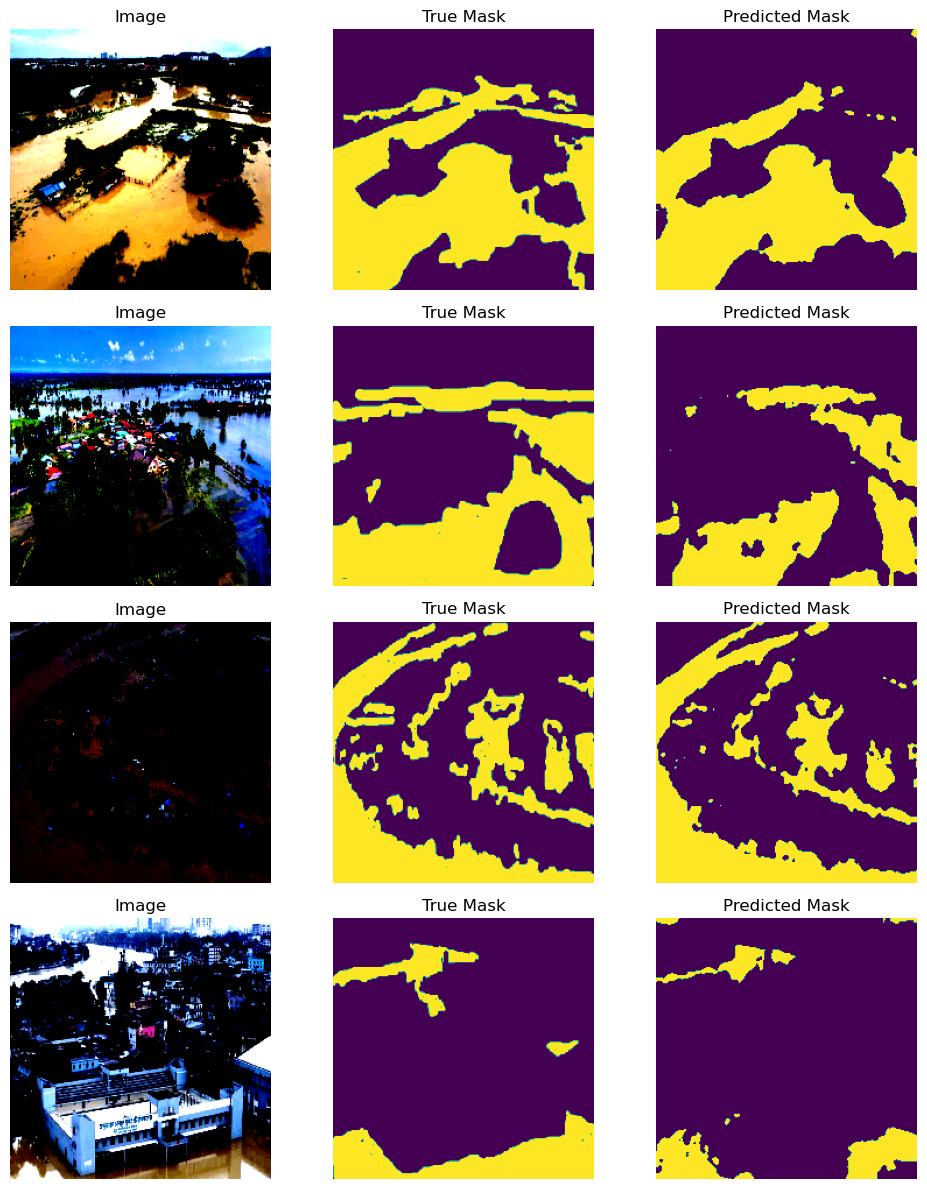

In [22]:
plot_number = 4
fig, ax = plt.subplots(plot_number,3,figsize=(10,plot_number*3))
Unet.eval()
test_mask = Unet(image.to(device))
prob = F.sigmoid(test_mask)
predicted = (prob > 0.5).float()
with torch.no_grad():
    for i in range(plot_number):
        ax[i,0].imshow(image[i].cpu().permute(1,2,0))
        ax[i,0].axis('off')
        ax[i,0].set_title('Image')
        ax[i,1].imshow(mask[i].squeeze(0).cpu().numpy())
        ax[i,1].axis('off')
        ax[i,1].set_title('True Mask')
        ax[i,2].imshow(predicted.cpu().detach().numpy()[i].squeeze(0))
        ax[i,2].axis('off')
        ax[i,2].set_title('Predicted Mask')
        fig.tight_layout()
plt.show()

In [23]:
# Convert to 0-255 uint8
TO_GIF = [(x*255).astype(np.uint8) for x in TO_GIF]

## Generate GIF

In [24]:
utils.create_gif(images = TO_GIF,
                sample_image = Resize((224,224))(sample_image.squeeze(0)).permute(1,2,0), 
                 gif_name= 'sample_segmentation', 
                fps=3)

c:\Users\wayne\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# END